Demo notebook where we will run our algorithm against test samples.

In [1]:
import sys

sys.path.append("../src")

In [2]:
%load_ext autoreload
%autoreload 2

from graph.mapping import embed_problem_to_QPU
from rdkit import Chem
from draw.features import draw_docking, draw_feature_list, draw_multiple_dockings
from draw.graph import draw_interaction_graph, draw_multiple_cliques
from graph.interaction_graph import (
    build_binding_interaction_graph,
    build_distance_matrix,
)
from mol_processing.features import name_features_by_count
from mol_processing.mol import get_features
from pulser.devices import Chadoq2


ImportError: cannot import name 'HashTrieMap' from 'rpds' (/Users/mathieug/miniforge3/envs/pasqal/lib/python3.11/site-packages/rpds/__init__.py)

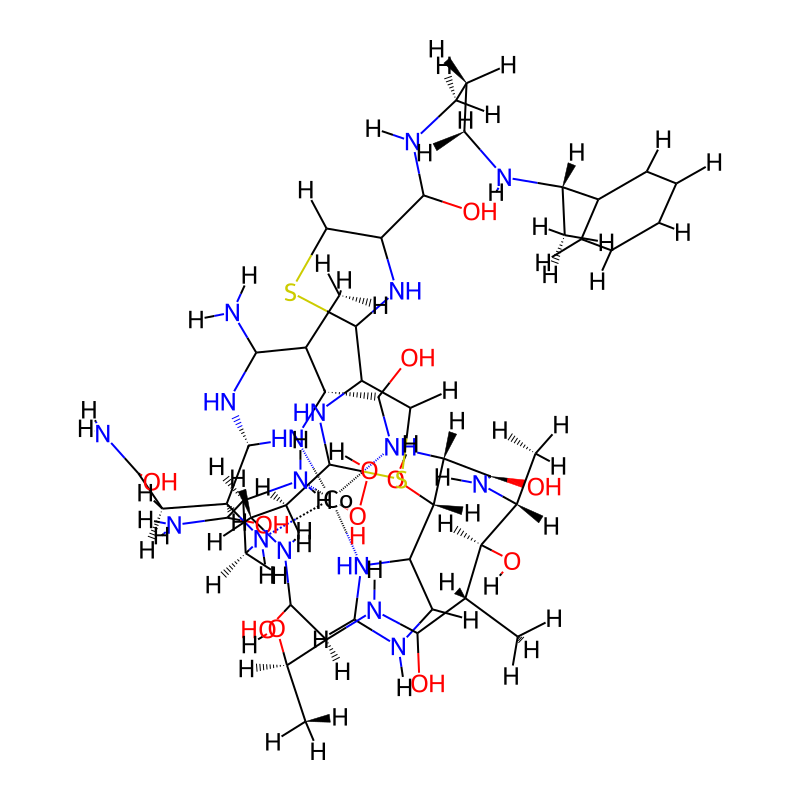

In [ ]:
mol = Chem.MolFromPDBFile("../data/receptors/1AO2.pdb", sanitize=True, removeHs=False)
rdkit.Chem.Draw.MolToImage(mol, size=(800, 800), kekulize=True, wedgeBonds=True, fitImage=True)

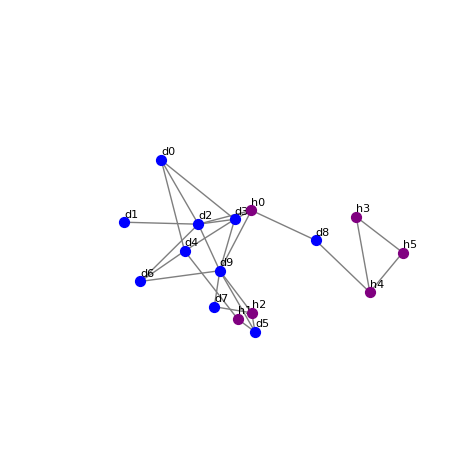

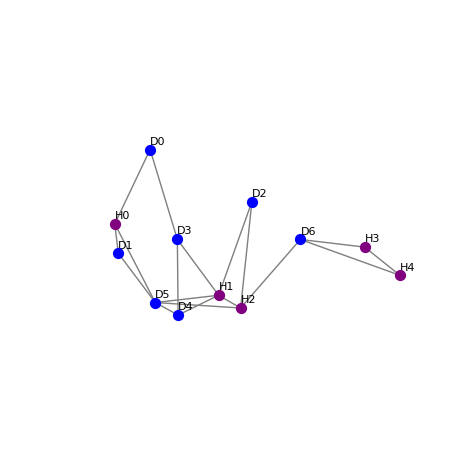

In [ ]:
R_features = get_features(mol, "receptor")[1::3]
L_features = get_features(mol, "ligand")[1::4]

name_features_by_count(R_features, is_ligand=False)
name_features_by_count(L_features, is_ligand=True)

R_distance_matrix = build_distance_matrix(R_features)
L_distance_matrix = build_distance_matrix(L_features)

draw_feature_list(R_features, R_distance_matrix)
draw_feature_list(L_features, L_distance_matrix)

In [ ]:
import networkx as nx

interaction_graph = build_binding_interaction_graph(L_distance_matrix, R_distance_matrix)
draw_interaction_graph(interaction_graph)

In [ ]:
from solver.classical import find_max_clique

max_clique = find_max_clique(interaction_graph)
print(max_clique)

<function find_max_clique at 0x12f341b20>


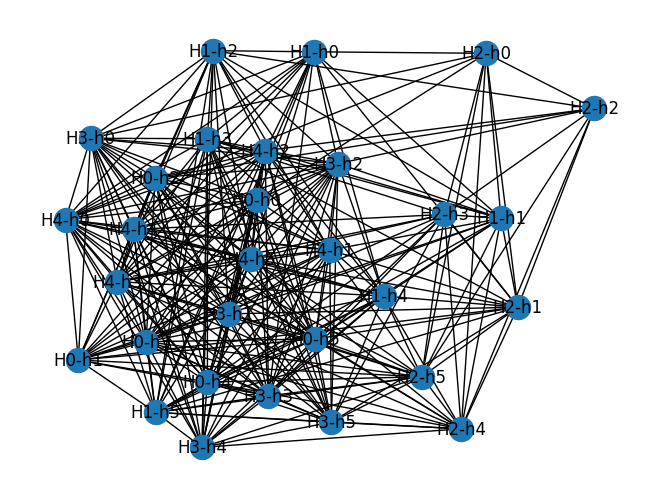

In [ ]:
# MAPPING TO UDG

from graph.mapping import *

compl = build_complementary_graph(interaction_graph)
pos = nx.spring_layout(compl)  # , seed=39299899

nx.draw(
    compl,
    pos=pos,
    with_labels=True,
    node_color="tab:blue",
)

In [ ]:
# register = embed_problem_to_QPU(interaction_graph)

# register.draw(
#     blockade_radius=Chadoq2.rydberg_blockade_radius(1.0), draw_graph=True, draw_half_radius=True
# )

In [ ]:
# QUANTUM SOLVER

In [ ]:
cliques = [["H2-h2", "H2-h0", "H2-h1"], ["H3-h0", "H3-h1", "H4-h4"]]

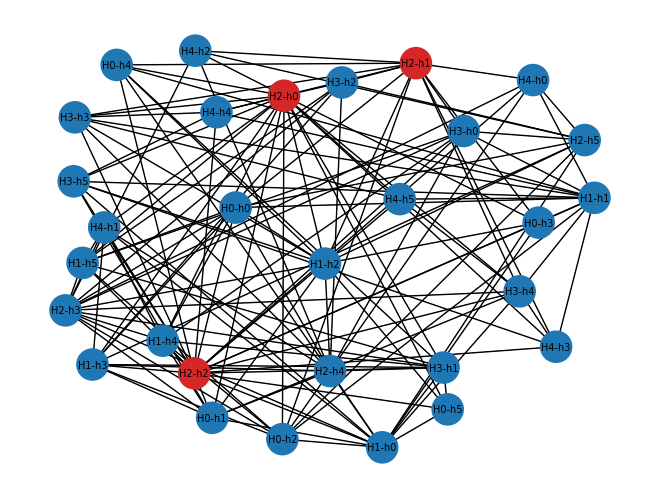

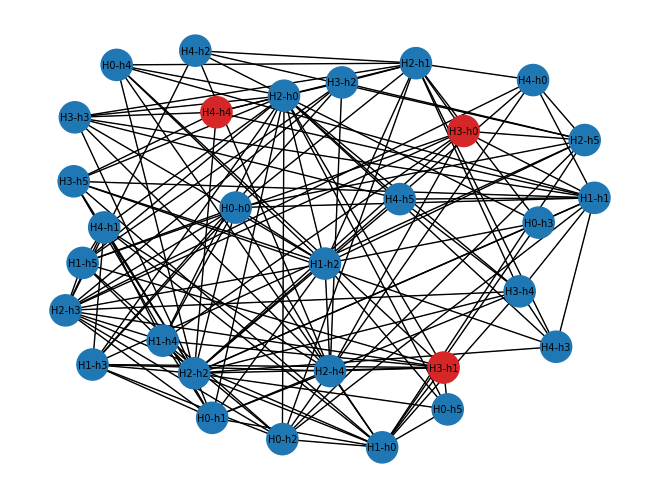

In [ ]:
draw_multiple_cliques(interaction_graph, cliques)

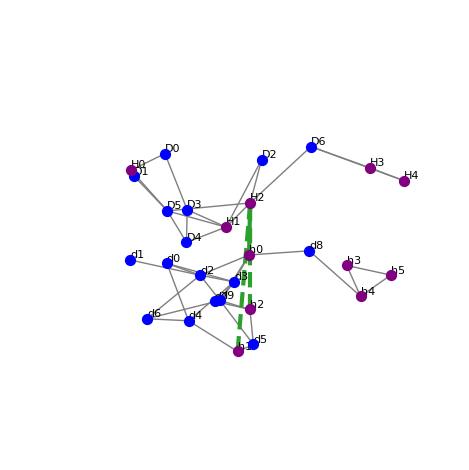

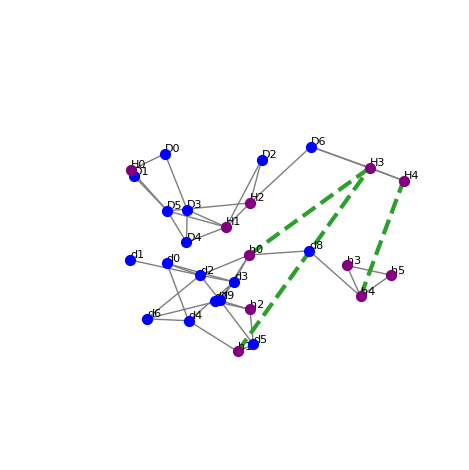

In [ ]:
draw_multiple_dockings(
    L_features, L_distance_matrix, R_features, R_distance_matrix, cliques_list=cliques
)